# 필요 모듈 로딩

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import FinanceDataReader as fdr
import pandas_datareader as pdr

from module import stationarity_adf_test, stationarity_kpss_test

from IPython.display import display_html
def display_side_by_side(*args):
    """여러 데이터프레임 비교가 쉽게 옆쪽으로 표시한다"""
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

# 전처리

## spread 전처리

In [2]:
# fred에서 fdr을 이용해 미 국채 장단기 금리차(10년물-2년물)을 크롤링해옵니다.
spread = fdr.DataReader('T10Y2Y', start='1990-06-01', data_source='fred')
spread

,T10Y2Y
DATE,
1990-06-01,0.11
1990-06-04,0.13
1990-06-05,0.13
1990-06-06,0.12
1990-06-07,0.12
...,...
2022-06-01,0.28
2022-06-02,0.27
2022-06-03,0.30


In [3]:
# spread = pd.read_csv("C:/Users/wkdgu/시계열/실습/미 국채 장단기 금리차.csv")
# 위 방식대로 가져오면 T10Y2Y의 데이터 타입이 object형으로 가져옵니다.

spread.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8353 entries, 1990-06-01 to 2022-06-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T10Y2Y  8353 non-null   float64
dtypes: float64(1)
memory usage: 130.5 KB


In [4]:
# 2022년 6월 2일 데이터는 빼줍니다.
spread = spread.iloc[:-1, :]
spread

,T10Y2Y
DATE,
1990-06-01,0.11
1990-06-04,0.13
1990-06-05,0.13
1990-06-06,0.12
1990-06-07,0.12
...,...
2022-05-31,0.32
2022-06-01,0.28
2022-06-02,0.27


In [5]:
# T10Y2Y을 Spread로 바꿔줍니다.
spread.rename(columns={'T10Y2Y':'spread'}, inplace = True)

In [6]:
spread

,spread
DATE,
1990-06-01,0.11
1990-06-04,0.13
1990-06-05,0.13
1990-06-06,0.12
1990-06-07,0.12
...,...
2022-05-31,0.32
2022-06-01,0.28
2022-06-02,0.27


In [7]:
# 시간 빈도를 월로 잡아줍니다.
# spread = spread.asfreq('M')
# spread

In [8]:
# 일단위 spread을 월단위로 빈도를 설정하다 결측치가 110개 나왔습니다.
# spread.isnull().sum()

In [9]:
# 결측리를 모두 빼줍니다.
# spread.dropna(axis = 0, inplace = True)

In [10]:
# spread

## jpm 전처리

In [11]:
jpm = pd.read_csv("C:/Users/wkdgu/시계열/실습/JPM.daily.csv")
jpm

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-06-01,9.21,9.33,9.08,9.33,3.38,1617600
1,1990-06-04,9.38,9.46,9.21,9.46,3.43,1354200
2,1990-06-05,9.54,9.62,9.50,9.58,3.47,1629300
3,1990-06-06,9.62,9.71,9.46,9.54,3.46,1200000
4,1990-06-07,9.50,9.54,9.42,9.50,3.44,1105800
...,...,...,...,...,...,...,...
8058,2022-05-25,126.28,127.86,125.17,127.24,127.24,12780400
8059,2022-05-26,128.37,130.19,128.21,129.44,129.44,15990900
8060,2022-05-27,130.16,131.27,129.14,131.27,131.27,11177800
8061,2022-05-31,130.18,133.15,129.71,132.23,132.23,17015000


In [12]:
jpm['Date'] = pd.to_datetime(jpm['Date'])

In [13]:
jpm

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-06-01,9.21,9.33,9.08,9.33,3.38,1617600
1,1990-06-04,9.38,9.46,9.21,9.46,3.43,1354200
2,1990-06-05,9.54,9.62,9.50,9.58,3.47,1629300
3,1990-06-06,9.62,9.71,9.46,9.54,3.46,1200000
4,1990-06-07,9.50,9.54,9.42,9.50,3.44,1105800
...,...,...,...,...,...,...,...
8058,2022-05-25,126.28,127.86,125.17,127.24,127.24,12780400
8059,2022-05-26,128.37,130.19,128.21,129.44,129.44,15990900
8060,2022-05-27,130.16,131.27,129.14,131.27,131.27,11177800
8061,2022-05-31,130.18,133.15,129.71,132.23,132.23,17015000


In [14]:
jpm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8063 entries, 0 to 8062
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8063 non-null   datetime64[ns]
 1   Open       8063 non-null   float64       
 2   High       8063 non-null   float64       
 3   Low        8063 non-null   float64       
 4   Close      8063 non-null   float64       
 5   Adj Close  8063 non-null   float64       
 6   Volume     8063 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 441.1 KB


In [15]:
jpm.rename(columns={'Date':'DATE'}, inplace=True)

In [16]:
jpm

,DATE,Open,High,Low,Close,Adj Close,Volume
0,1990-06-01,9.21,9.33,9.08,9.33,3.38,1617600
1,1990-06-04,9.38,9.46,9.21,9.46,3.43,1354200
2,1990-06-05,9.54,9.62,9.50,9.58,3.47,1629300
3,1990-06-06,9.62,9.71,9.46,9.54,3.46,1200000
4,1990-06-07,9.50,9.54,9.42,9.50,3.44,1105800
...,...,...,...,...,...,...,...
8058,2022-05-25,126.28,127.86,125.17,127.24,127.24,12780400
8059,2022-05-26,128.37,130.19,128.21,129.44,129.44,15990900
8060,2022-05-27,130.16,131.27,129.14,131.27,131.27,11177800
8061,2022-05-31,130.18,133.15,129.71,132.23,132.23,17015000


In [17]:
jpm.set_index('DATE', inplace = True)

In [18]:
jpm

,Open,High,Low,Close,Adj Close,Volume
DATE,,,,,,
1990-06-01,9.21,9.33,9.08,9.33,3.38,1617600
1990-06-04,9.38,9.46,9.21,9.46,3.43,1354200
1990-06-05,9.54,9.62,9.50,9.58,3.47,1629300
1990-06-06,9.62,9.71,9.46,9.54,3.46,1200000
1990-06-07,9.50,9.54,9.42,9.50,3.44,1105800
...,...,...,...,...,...,...
2022-05-25,126.28,127.86,125.17,127.24,127.24,12780400
2022-05-26,128.37,130.19,128.21,129.44,129.44,15990900
2022-05-27,130.16,131.27,129.14,131.27,131.27,11177800


In [19]:
jpm = jpm[['Close']]
jpm

,Close
DATE,
1990-06-01,9.33
1990-06-04,9.46
1990-06-05,9.58
1990-06-06,9.54
1990-06-07,9.50
...,...
2022-05-25,127.24
2022-05-26,129.44
2022-05-27,131.27


In [20]:
# jpm = jpm.asfreq('M')
# jpm

In [21]:
# 일단위 jpm을 월단위로 빈도를 설정하다 결측치가 115개 나왔습니다.
# jpm.isnull().sum()

In [22]:
# jpm.dropna(axis = 0, inplace = True)

In [23]:
# jpm

## XLF 전처리

In [24]:
xlf = pd.read_csv("C:/Users/wkdgu/시계열/실습/XLF.csv")
xlf

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-06-01,20.26,20.36,19.85,20.08,12.73,256417
1,1999-06-02,19.98,20.11,19.62,19.95,12.65,126178
2,1999-06-03,20.21,20.21,19.88,19.94,12.64,87155
3,1999-06-04,20.18,20.38,20.05,20.31,12.88,91340
4,1999-06-07,20.44,20.71,20.36,20.69,13.12,60319
...,...,...,...,...,...,...,...
5785,2022-05-25,33.84,34.40,33.74,34.19,34.19,72192600
5786,2022-05-26,34.56,35.10,34.53,34.98,34.98,50803200
5787,2022-05-27,35.13,35.64,35.07,35.57,35.57,43862500
5788,2022-05-31,35.28,35.74,35.09,35.47,35.47,64778900


In [25]:
xlf['Date'] = pd.to_datetime(xlf['Date'])

In [26]:
xlf.rename(columns={'Date':'DATE'}, inplace=True)
xlf.set_index('DATE', inplace = True)
xlf = xlf[['Close']]
xlf

,Close
DATE,
1999-06-01,20.08
1999-06-02,19.95
1999-06-03,19.94
1999-06-04,20.31
1999-06-07,20.69
...,...
2022-05-25,34.19
2022-05-26,34.98
2022-05-27,35.57


## spread와 jpm을 합쳐줍니다.

In [27]:
jpm_spread = pd.merge(spread, jpm, how='inner', on='DATE')
jpm_spread

,spread,Close
DATE,,
1990-06-01,0.11,9.33
1990-06-04,0.13,9.46
1990-06-05,0.13,9.58
1990-06-06,0.12,9.54
1990-06-07,0.12,9.50
...,...,...
2022-05-25,0.27,127.24
2022-05-26,0.29,129.44
2022-05-27,0.27,131.27


## jpm,xlf,spread를 합쳐줍니다.

In [28]:
# Close_x = jpm, Close_y = XLF
jpm_xlf_spread = pd.merge(jpm_spread, xlf, how='inner', on='DATE')
jpm_xlf_spread

,spread,Close_x,Close_y
DATE,,,
1999-06-01,0.24,48.08,20.08
1999-06-02,0.25,47.38,19.95
1999-06-03,0.26,47.75,19.94
1999-06-04,0.26,49.54,20.31
1999-06-07,0.25,51.17,20.69
...,...,...,...
2022-05-25,0.27,127.24,34.19
2022-05-26,0.29,129.44,34.98
2022-05-27,0.27,131.27,35.57


## jpm, spread 시각화합니다.

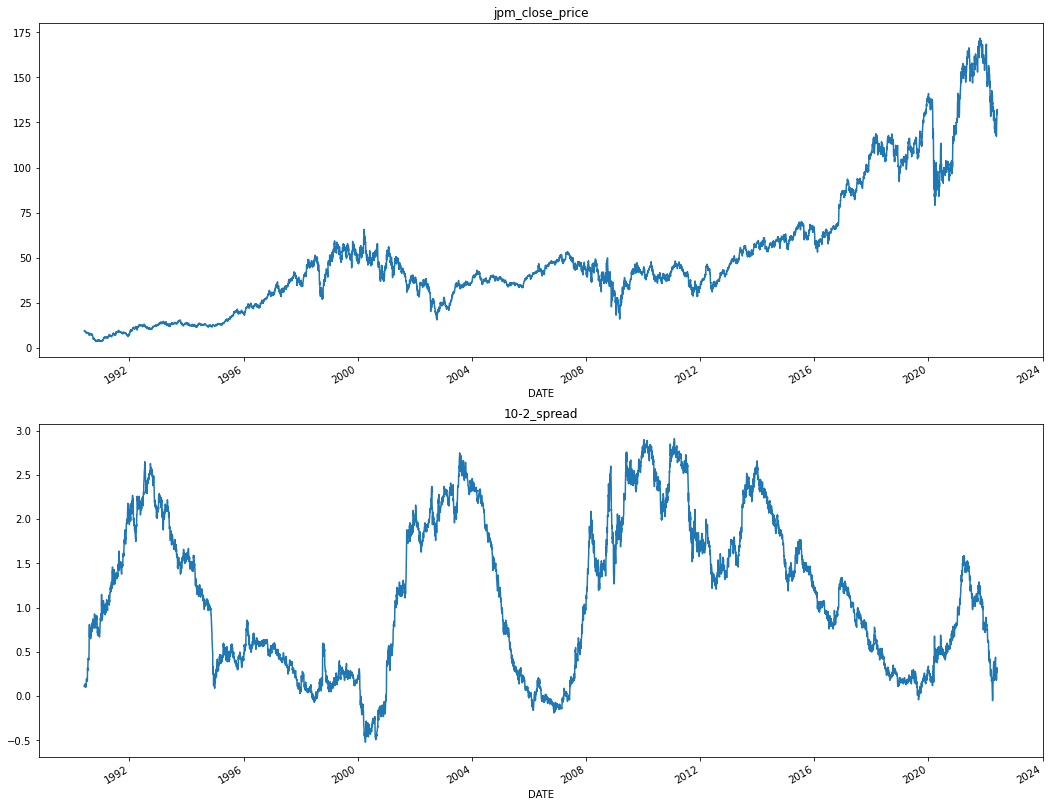

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(18,15))
jpm_spread['Close'].plot(ax = axs[0], title = 'jpm_close_price')
jpm_spread['spread'].plot(ax = axs[1], title = '10-2_spread')
plt.show()

## xlf 시각화

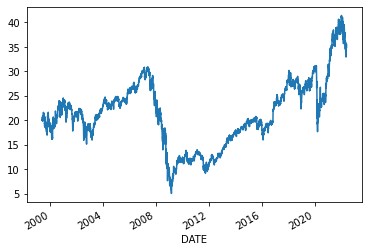

In [52]:
jpm_xlf_spread['Close_y'].plot()
plt.show()

# 데이터 변환

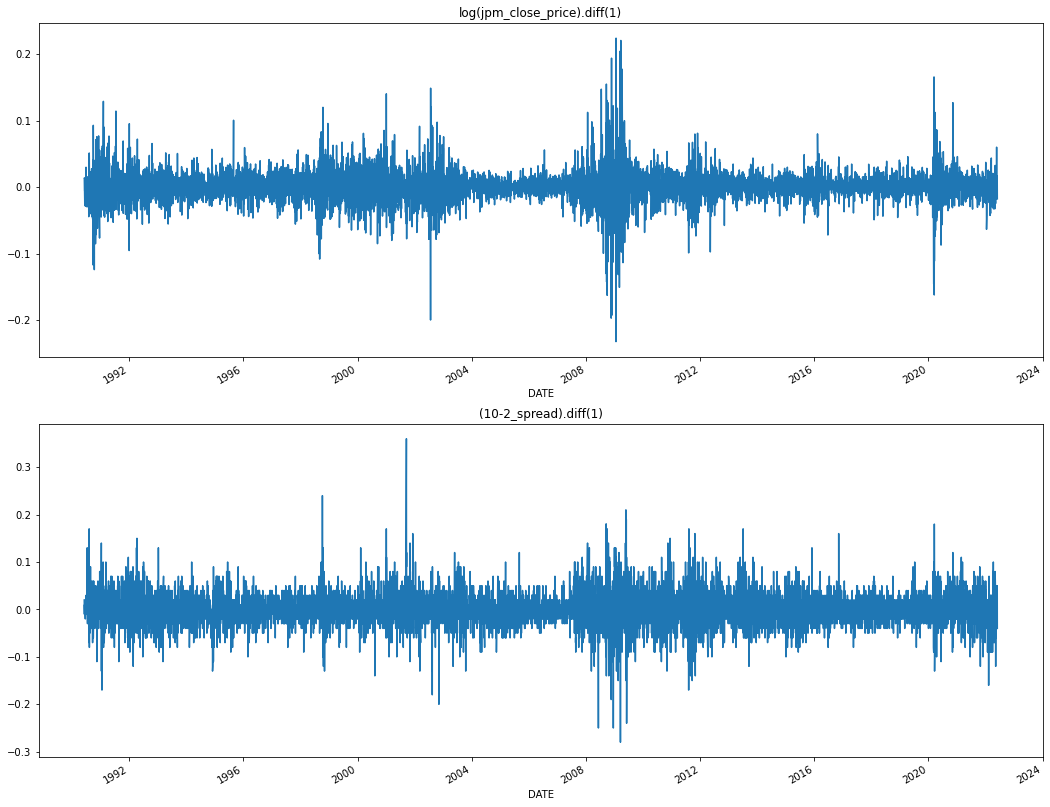

In [30]:
# jpm_close는 로그씌우고 차분, spread는 차분만 해줍니다.
fig, axs = plt.subplots(2, 1, figsize=(18,15))
np.log(jpm_spread['Close']).diff(1).dropna().plot(ax = axs[0], title = 'log(jpm_close_price).diff(1)')
jpm_spread['spread'].diff(1).dropna().plot(ax = axs[1], title = '(10-2_spread).diff(1)')
plt.show()

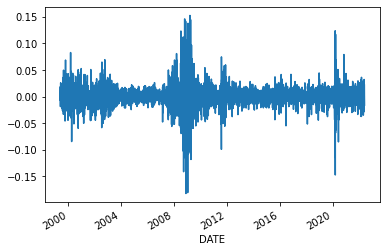

In [55]:
# xlf 데이터 로그씌우고 차분 시각화
np.log(jpm_xlf_spread['Close_y']).diff(1).dropna().plot()
plt.show()

In [57]:
# 로그 씌우고 차분한 xlf adf테스트 결과 단위근 없음
sm.tsa.stattools.adfuller(np.log(jpm_xlf_spread['Close_y']).diff(1).dropna(), maxlag=3, autolag=None)

(-40.86776449576335,
 0.0,
 3,
 5785,
 {'1%': -3.4314808909275203,
  '5%': -2.8620397464285667,
  '10%': -2.5670360130624235})

# 정상성 테스트

## adf테스트

### jpm의 종가데이터

In [31]:
# adf테스트에서 일단 상수항이 있다고 가정(디폴트값)합니다.
# 분기는 lag=3, 월은 lag=6~10으로 많이 씁니다. 하지만 보통 lag는 3으로 씁니다. (이서진 교수님 왈)
# 나는 일단위 데이터인데 lag=3으로 해도 되나?
sm.tsa.stattools.adfuller(np.log(jpm_spread['Close']).diff(1).dropna(), maxlag=3, autolag=None)

# 첫번째는 adf 통계량입니다.
# 두번째는 p-value입니다.
# 세번째는 사용한 lag입니다. The number of lags used.
# 네번째는 관측치의 수입니다.
# 딕셔너리 형태인 다섯번째는 유의수준에 따른 critical value입니다.
# 마지막은 The maximized information criterion if autolag is not None.

(-47.34885677511827,
 0.0,
 3,
 8058,
 {'1%': -3.4311617875863143,
  '5%': -2.8618987523029547,
  '10%': -2.5669609591210807})

In [32]:
# 보기 좋게 만들기 위해 adf 통계량, p-vlaue, 사용한 lag, 관측치의 수만 따로 뽑습니다.
sm.tsa.stattools.adfuller(np.log(jpm_spread['Close']).diff(1).dropna(), maxlag=3, autolag=None)[0:4]

(-47.34885677511827, 0.0, 3, 8058)

In [33]:
# 시리즈 형태로 붙이고 인덱스를 붙여줍니다.
Stationarity = pd.Series(sm.tsa.stattools.adfuller(np.log(jpm_spread['Close']).diff(1).dropna(), maxlag=3, autolag=None)[0:4],
         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Stationarity

Test Statistics       -47.35
p-value                 0.00
Used Lag                3.00
Used Observations   8,058.00
dtype: float64

In [34]:
# 딕셔너리 형태인 다섯번째는 유의수준에 따른 critical value도 Series에 넣어줍니다.
for key, value in sm.tsa.stattools.adfuller(np.log(jpm_spread['Close']).diff(1).dropna())[4].items():
    Stationarity['Critical Value(%s)'%key] = value

In [35]:
Stationarity

Test Statistics         -47.35
p-value                   0.00
Used Lag                  3.00
Used Observations     8,058.00
Critical Value(1%)       -3.43
Critical Value(5%)       -2.86
Critical Value(10%)      -2.57
dtype: float64

In [36]:
# 마지막인 The maximized information criterion if autolag is not None도 Series에 넣어줍니다.
Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(np.log(jpm_spread['Close']).diff(1).dropna())[5]
Stationarity

Test Statistics                    -47.35
p-value                              0.00
Used Lag                             3.00
Used Observations                8,058.00
Critical Value(1%)                  -3.43
Critical Value(5%)                  -2.86
Critical Value(10%)                 -2.57
Maximum Information Criteria   -37,354.41
dtype: float64

In [37]:
# DataFrame 형태로 변환해줍니다.
Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])
Stationarity

,Stationarity
Test Statistics,-47.35
p-value,0.00
Used Lag,3.00
Used Observations,"8,058.00"
Critical Value(1%),-3.43
Critical Value(5%),-2.86
Critical Value(10%),-2.57
Maximum Information Criteria,"-37,354.41"


### spread 데이터

In [38]:
# adf테스트에서 일단 상수항이 있다고 가정(디폴트값)합니다.
# 분기는 lag=3, 월은 lag=6~10으로 많이 씁니다. 하지만 보통 lag는 3으로 씁니다. (이서진 교수님 왈)
# 나는 일단위 데이터인데 lag=3으로 해도 되나?

sm.tsa.stattools.adfuller(jpm_spread['spread'].diff(1).dropna(), maxlag=3, autolag=None)

(-46.31620156375627,
 0.0,
 3,
 8058,
 {'1%': -3.4311617875863143,
  '5%': -2.8618987523029547,
  '10%': -2.5669609591210807})

In [39]:
# 보기 좋게 만들기 위해 adf 통계량, p-vlaue, 사용한 lag, 관측치의 수만 따로 뽑습니다.
sm.tsa.stattools.adfuller(jpm_spread['spread'].diff(1).dropna(), maxlag=3, autolag=None)[0:4]

(-46.31620156375627, 0.0, 3, 8058)

In [40]:
# 시리즈 형태로 붙이고 인덱스를 붙여줍니다.
Stationarity = pd.Series(sm.tsa.stattools.adfuller(jpm_spread['spread'].diff(1).dropna(), maxlag=3, autolag=None)[0:4],
         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Stationarity

Test Statistics       -46.32
p-value                 0.00
Used Lag                3.00
Used Observations   8,058.00
dtype: float64

In [41]:
# 딕셔너리 형태인 다섯번째는 유의수준에 따른 critical value도 Series에 넣어줍니다.
for key, value in sm.tsa.stattools.adfuller(jpm_spread['Close'].diff(1).dropna())[4].items():
    Stationarity['Critical Value(%s)'%key] = value

In [42]:
Stationarity

Test Statistics         -46.32
p-value                   0.00
Used Lag                  3.00
Used Observations     8,058.00
Critical Value(1%)       -3.43
Critical Value(5%)       -2.86
Critical Value(10%)      -2.57
dtype: float64

In [43]:
# 마지막인 The maximized information criterion if autolag is not None도 Series에 넣어줍니다.
Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(np.log(jpm_spread['Close']).diff(1).dropna())[5]
Stationarity

Test Statistics                    -46.32
p-value                              0.00
Used Lag                             3.00
Used Observations                8,058.00
Critical Value(1%)                  -3.43
Critical Value(5%)                  -2.86
Critical Value(10%)                 -2.57
Maximum Information Criteria   -37,354.41
dtype: float64

In [44]:
# DataFrame 형태로 변환해줍니다.
Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])
Stationarity

,Stationarity
Test Statistics,-46.32
p-value,0.00
Used Lag,3.00
Used Observations,"8,058.00"
Critical Value(1%),-3.43
Critical Value(5%),-2.86
Critical Value(10%),-2.57
Maximum Information Criteria,"-37,354.41"


# OLS regression(nonrobust)

## jpm과 spread

In [87]:
# 기간은 1999년 6월 1일부터 2022년 6월 2일
# Durbin-Watson 검정통계량이 0에 가까워서 Positive Autocorrelation이 확인된다.
# Close_x = jpm, Close_y = XLF
model1 = smf.ols('Close_x ~ spread',data=jpm_xlf_spread).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                Close_x   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     974.5
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          7.31e-198
Time:                        20:55:51   Log-Likelihood:                -28262.
No. Observations:                5790   AIC:                         5.653e+04
Df Residuals:                    5788   BIC:                         5.654e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.7489      0.713    111.850      0.0

### breusch_godfrey(Autocorrelation) 테스트

In [78]:
import statsmodels.stats.diagnostic as dg

# 보통 lag는 3으로 많이 씁니다.(이서진 교수님 왈)
# 귀무가설 : Autocorrelation이 없다.
# 대립가설 : Autocorrelation이 있다.
# p-value가 0이므로 Autocorrelation이 있습니다....
dg.acorr_breusch_godfrey(model, nlags=3)

(5776.239392769398, 0.0, 809449.3779034852, 0.0)

### 시차별 잔차도를 통한 Autocorrelaion 시각화

In [79]:
# ols를 돌린 model의 잔차를 확인
model.resid

DATE
1999-06-01   -28.15
1999-06-02   -28.71
1999-06-03   -28.19
1999-06-04   -26.39
1999-06-07   -24.92
              ...  
2022-05-25    51.45
2022-05-26    53.94
2022-05-27    55.48
2022-05-31    57.17
2022-06-01    54.27
Length: 5790, dtype: float64

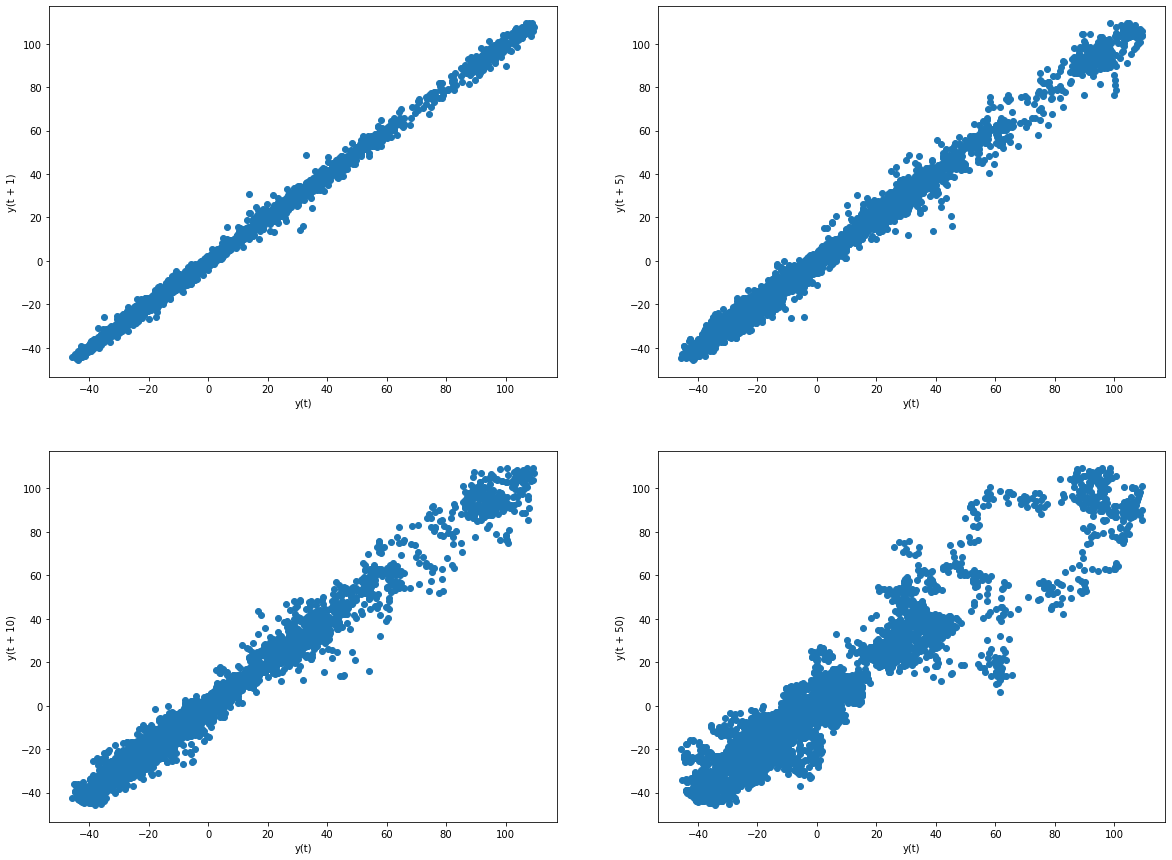

In [80]:
# 1,5,10,50 시차별 잔차도 시각화

figure, axes = plt.subplots(2,2, figsize = (20,15))
pd.plotting.lag_plot(model.resid, lag=1, ax=axes[0][0])
pd.plotting.lag_plot(model.resid, lag=5, ax=axes[0][1])
pd.plotting.lag_plot(model.resid, lag=10, ax=axes[1][0])
pd.plotting.lag_plot(model.resid, lag=50, ax=axes[1][1])
plt.show()

## xlf와 spread

In [86]:
# Close_x = jpm, Close_y = XLF
model2 = smf.ols('Close_y ~ spread',data=jpm_xlf_spread).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                Close_y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     3297.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:55:42   Log-Likelihood:                -18031.
No. Observations:                5790   AIC:                         3.607e+04
Df Residuals:                    5788   BIC:                         3.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.0092      0.122    221.720      0.0

### breusch_godfrey(Autocorrelation) 테스트

In [88]:
import statsmodels.stats.diagnostic as dg

# 보통 lag는 3으로 많이 씁니다.(이서진 교수님 왈)
# 귀무가설 : Autocorrelation이 없다.
# 대립가설 : Autocorrelation이 있다.
# p-value가 0이므로 Autocorrelation이 있습니다....
dg.acorr_breusch_godfrey(model2, nlags=3)

(5759.4467919255485, 0.0, 363501.37777243275, 0.0)

### 시차별 잔차도를 통한 Autocorrelaion 시각화

In [89]:
# ols를 돌린 model의 잔차를 확인
model2.resid

DATE
1999-06-01   -5.82
1999-06-02   -5.90
1999-06-03   -5.87
1999-06-04   -5.50
1999-06-07   -5.17
              ... 
2022-05-25    8.42
2022-05-26    9.31
2022-05-27    9.80
2022-05-31    9.94
2022-06-01    9.18
Length: 5790, dtype: float64

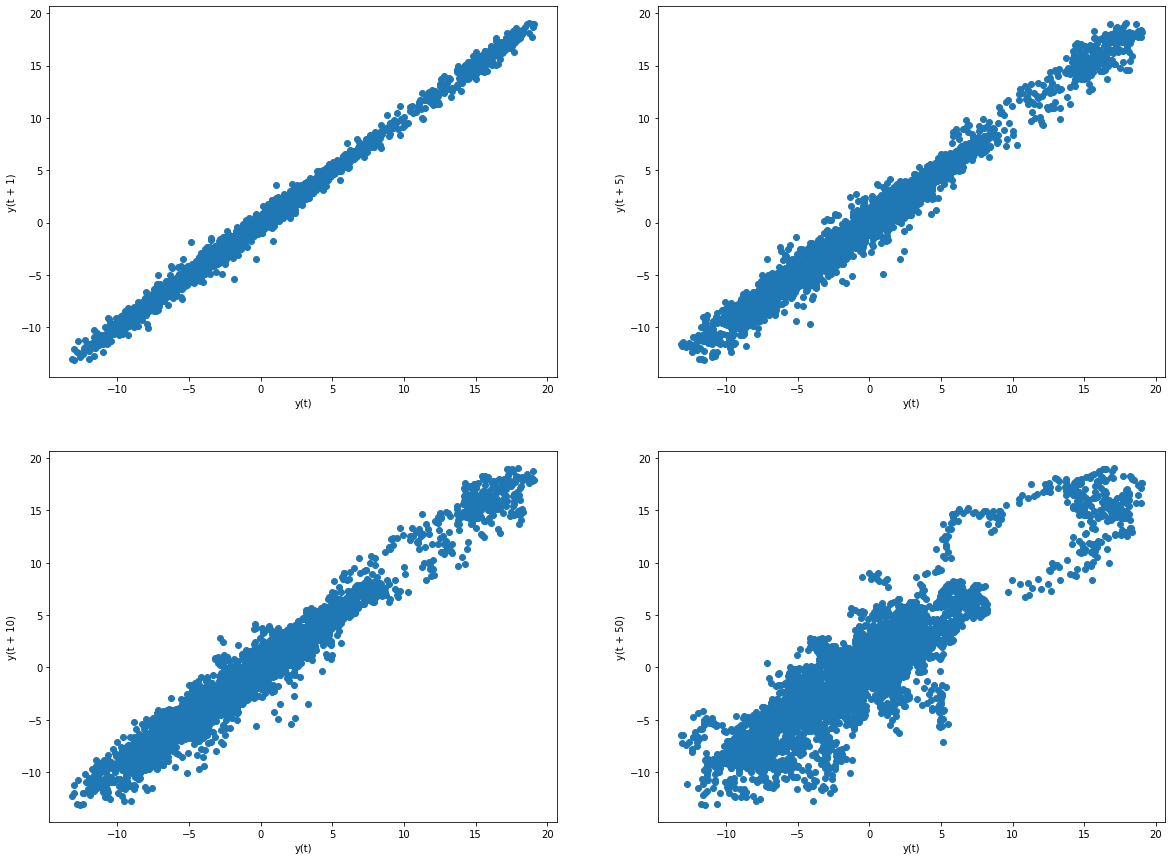

In [90]:
# 1,5,10,50 시차별 잔차도 시각화

figure, axes = plt.subplots(2,2, figsize = (20,15))
pd.plotting.lag_plot(model2.resid, lag=1, ax=axes[0][0])
pd.plotting.lag_plot(model2.resid, lag=5, ax=axes[0][1])
pd.plotting.lag_plot(model2.resid, lag=10, ax=axes[1][0])
pd.plotting.lag_plot(model2.resid, lag=50, ax=axes[1][1])
plt.show()

# OLS regression(HAC estimator)

## jpm과 spread

In [91]:
# Close_x = jpm, Close_y = XLF
model1_hac = smf.ols('Close_x ~ spread',data=jpm_xlf_spread).fit(cov_type='HAC',cov_kwds={'maxlags':3}, use_t=True)
print(model1_hac.summary())

                            OLS Regression Results                            
Dep. Variable:                Close_x   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     341.8
Date:                Wed, 08 Jun 2022   Prob (F-statistic):           3.34e-74
Time:                        20:57:20   Log-Likelihood:                -28262.
No. Observations:                5790   AIC:                         5.653e+04
Df Residuals:                    5788   BIC:                         5.654e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.7489      1.603     49.741      0.0

## xlf와 spread

In [93]:
# Close_x = jpm, Close_y = XLF
model2_hac = smf.ols('Close_y ~ spread',data=jpm_xlf_spread).fit(cov_type='HAC',cov_kwds={'maxlags':3}, use_t=True)
print(model2_hac.summary())

                            OLS Regression Results                            
Dep. Variable:                Close_y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     1170.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          1.10e-233
Time:                        20:57:51   Log-Likelihood:                -18031.
No. Observations:                5790   AIC:                         3.607e+04
Df Residuals:                    5788   BIC:                         3.608e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.0092      0.227    118.870      0.0